## Time series - Demand - Forecasting
https://www.kaggle.com/c/demand-forecasting-kernels-only

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [326]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import itertools
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
%matplotlib inline

In [3]:
#Set data paths 
time_series_train_path = Path('../data/time_series_train.csv')
time_series_test_path = Path('../data/time_series_test.csv')

In [4]:
#Load dataframe
train_df = pd.read_csv(time_series_train_path, parse_dates=['date'])
test_df = pd.read_csv(time_series_test_path, parse_dates=['date'], index_col=['id'])

In [5]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
test_df.head()

,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


## Data pre-processing

In [7]:
#Function to extract rolling average and take difference in attempt to create stationary time series
def sales_transform(dataf):
    
    new_df = (dataf
              .assign(sales_diff = dataf['sales'].diff(1)
                     )
             )
    
    return new_df

#Function to split dataframe per store/item combination to model separately
def split_data(dataf, store, item):
    
    splitted_df = dataf[(dataf['store'] == store) & (dataf['item'] == item)]
    
    return splitted_df

In [8]:
#Create list with all unique combinations of store and item
stores = [s for s in range(1,11)]
items = [i for i in range(1,51)]
combinations = list(itertools.product(stores, items))

In [9]:
#Create list containing dataframes for all store/item combinations
list_train_df_split = []

for s, i in combinations:
    list_train_df_split.append(train_df.pipe(split_data, store=s, item=i))  

In [12]:
#First item in dataframe list
list_train_df_split[0]

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1821,2017-12-27,1,1,14
1822,2017-12-28,1,1,19
1823,2017-12-29,1,1,15
1824,2017-12-30,1,1,27


## SARIMA (Seasonal ARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

### Trend elements

There are three trend elements that require configuration.
They are the same as the ARIMA model; specifically:

- p: Trend autoregression order: The number of lag observations included in the model, also called the lag order
- d: Trend difference order: The number of times that the raw observations are differenced, also called the degree of differencing
- q: Trend moving average order: The size of the moving average window, also called the order of moving average

### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.  If the lag m has a positive value then P should be >= 1. Otherwise P should be 0. 
- D: Seasonal difference order. The rule of thumb for our D parameter is that our series differencing and seasonal differencing should not be greater than 2. If our seasonal pattern is stable overtime then we can set D=1 and set D=0 if the seasonal pattern seems unstable.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. The value m is equal to the lag with the greatest autocorrelation coefficient.

In [73]:
#Function to run separate SARIMAX models per store/item and output predictions to DataFrame
def predict_sarimax(list_dataf):
    
    #Create empty series to append to
    dates = pd.Series(dtype='datetime64[ns]')
    stores = pd.Series(dtype='int64')
    items = pd.Series(dtype='int64')
    actual_sales = pd.Series(dtype='int64')
    predicted_sales = pd.Series(dtype='int64')
   
    #Loop to dataframes and calculate predictions        
    for dataframe in list_dataf:

        #Append relevant data to main lists per store/item combination
        dates = (dates
                     .append(dataframe['date'])
                     .append(pd.Series(pd.date_range('2018-01-01', '2018-03-31')))
                )
        stores = (stores
                      .append(dataframe['store'])
                      .append(pd.Series(np.full(90, dataframe['store'].unique())))
                 )
        
        items = (items
                      .append(dataframe['item'])
                      .append(pd.Series(np.full(90, dataframe['item'].unique())))
                )
        
         
        actual_sales = (actual_sales
                            .append(dataframe['sales'])
                            .append(pd.Series(np.zeros(90)))
                       )
                
        #Initiate Prophet model, fit and predict
        sarimax = sm.tsa.statespace.SARIMAX(dataframe['sales'].values, 
                                           order=(0,1,1), 
                                           seasonal_order=(0,1,1,7)
                                          )
        sarimax_fit = sarimax.fit()

        
        predicted_sales = predicted_sales.append(pd.Series(sarimax_fit
                                                              .get_prediction(start=0, end=1915, dynamic=False)
                                                              .predicted_mean
                                                          )
                                                )
        
            
    #Create new dataframe with predictions
    train_df_predictions = pd.DataFrame({'date': dates,
                                         'store': stores,
                                         'item': items,
                                         'actual_sales' : actual_sales.astype(int),
                                         'predicted_sales' : (predicted_sales
                                                              .values
                                                              .astype(int)
                                                             )
                                         }
                                       )
    
    return train_df_predictions

In [74]:
df_predictions_sarimax = predict_sarimax(list_train_df_split)

In [75]:
df_predictions_sarimax.head()

,date,store,item,actual_sales,predicted_sales
0,2013-01-01,1,1,13,0
1,2013-01-02,1,1,11,12
2,2013-01-03,1,1,14,11
3,2013-01-04,1,1,13,13
4,2013-01-05,1,1,10,13


In [148]:
#Visualize original versus predicted values for training dataset
def plot_original_predicted(dataf, min_date, max_date, store_id, item_id):
    
    df_selection = dataf[(dataf['date'] > min_date) & (dataf['date'] < max_date) & (dataf['store'] == store_id) & (dataf['item'] == item_id)]
        
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=df_selection['date'],
                             y=df_selection['actual_sales'],
                             mode='lines',
                             name='Actual Sales'
                            )
                 )
    
    fig.add_trace(go.Scatter(x=df_selection['date'],
                             y=df_selection['predicted_sales'],
                             mode='lines',
                             name='Predicted Sales'
                            )
                 )
    fig.show()

In [151]:
plot_original_predicted(df_predictions_sarimax, 
                        min_date='2013-08-01', 
                        max_date='2013-08-31',
                        store_id=5,
                        item_id=5)

In [154]:
#Set actual and predicted sales to calculate SMAPE 
y_actual_sarimax = df_predictions_sarimax[df_predictions_sarimax['date'] < '2018-01-01']['actual_sales']
y_pred_sarimax = df_predictions_sarimax[df_predictions_sarimax['date'] < '2018-01-01']['predicted_sales']

In [83]:
#Function to calculate smape for original versus predictions
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [155]:
#Calculate SMAPE
smape(y_actual_sarimax, y_pred_sarimax)

14.014676614729378

In [247]:
#Output predictions for first three months of 2018
predictions_sarimax = (df_predictions_sarimax[df_predictions_sarimax['date'] >= '2018-01-01']
                           .reset_index()['predicted_sales']
                      )

In [248]:
len(predictions_sarimax)

45000

In [276]:
predictions_sarimax

NameError: name 'predictions_sarimax' is not defined

In [250]:
save_path = Path('../data/time_series_SARIMAX_predictions.csv')

predictions_sarimax.to_csv(save_path)

## Prophet

The procedure makes use of a decomposable time series model with three main model components: trend, seasonality, and holidays.

y(t) = g(t) + s(t) + h(t) + e(t)


g(t)
- trend models non-periodic changes; linear or logistic

s(t)
- seasonality represents periodic changes; i.e. weekly, monthly, yearly

h(t)
- ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

The error term e(t) represents any idiosyncratic changes which are not accommodated by the model; later we will make the parametric assumption that e(t) is normally distributed.

In [441]:
class ProphetModel:
    
    #Initialize with list of dataframes per store/item and other fixed model input
    def __init__(self, list_dataf):
        
        self.list_dataf = list_dataf
        #Set holidays to include in model
        self.playoffs = pd.DataFrame({'holiday' : 'playoffs',
                                      'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24', '2014-01-12', 
                                                             '2014-07-12', '2014-07-19', '2014-07-02','2014-12-24', 
                                                             '2015-07-11', '2015-12-24', '2016-07-17', '2016-07-24', 
                                                             '2016-07-07','2016-07-24','2016-12-24', '2017-07-17',
                                                             '2017-07-24','2017-07-07','2017-12-24'
                                                             ]
                                                            ),
                                        #Used to identify spillover effect to previous of next days
                                        'lower_window' : 0,
                                        'upper_window' : 2
                                     }
                                    )
        
        self.superbowls = pd.DataFrame({'holiday': 'superbowl',
                                        'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
                                                              '2013-05-27','2013-07-04','2013-09-02','2013-10-14',
                                                              '2013-11-11','2013-11-28','2013-12-25','2014-01-01',
                                                              '2014-01-20','2014-02-14','2014-02-17', '2014-05-26',
                                                              '2014-07-04','2014-09-01','2014-10-13','2014-11-11',
                                                              '2014-11-27','2014-12-25','2015-01-01','2015-01-19',
                                                              '2015-02-14','2015-02-16','2015-05-25','2015-07-03',
                                                              '2015-09-07','2015-10-12','2015-11-11','2015-11-26',
                                                              '2015-12-25','2016-01-01','2016-01-18','2016-02-14',
                                                              '2016-02-15', '2016-05-30','2016-07-04','2016-09-05',
                                                              '2016-10-10','2016-11-11','2016-11-24','2016-12-25',
                                                              '2017-01-02','2017-01-16','2017-02-14','2017-02-20',
                                                              '2017-05-29','2017-07-04','2017-09-04','2017-10-09',
                                                              '2017-11-10','2017-11-23','2017-12-25','2018-01-01',
                                                              '2018-01-15','2018-02-14','2018-02-19'
                                                              ]
                                                             ),
                                            'lower_window': 0,
                                            'upper_window': 3,
                                        }
                                       )
        
        self.holidays = pd.concat((self.playoffs, self.superbowls))
        
        #Determine dates to predict
        self.dates_to_predict = (pd.DataFrame({'ds': (self.list_dataf[0]['date']
                                                          .append(pd.Series(pd.date_range('2018-01-01', '2018-03-31')))
                                                     )

                                              }
                                             )
                                )
    
    #Run Prophet model for multiple store/item combinations with different parameters and print SMAPE
    def predict_single_search(self, store_id, item_id):
        
        #Set parameter grid to tune model
        params = {'n_changepoints': [200, 400, 600, 800],
                  'changepoint_prior_scale':[0.2,0.4,0.6,0.8,1.0]
                 }
        grid = ParameterGrid(params)
        
        #Create evaluation dataframe
        evaluation_df = pd.DataFrame(columns=['model_parameters', 'MAPE'])
        
        for dataframe in list_train_df_split:
            
            if all(dataframe['store'] == store_id) and all(dataframe['item'] == item_id):
                
                #Create input dataframe for Prophet prediction
                input_df_prophet = pd.DataFrame({'ds': dataframe['date'],
                                                 'y': dataframe['sales']
                                                }
                                               )     
                
                #Use parameter grid to test different models
                for p in grid:
                
                    #Initiate Prophet model
                    ph_single = Prophet(n_changepoints=p['n_changepoints'],
                                        changepoint_prior_scale=p['changepoint_prior_scale'],
                                        seasonality_mode='multiplicative',
                                        daily_seasonality=False,
                                        weekly_seasonality=False,
                                        yearly_seasonality=False
                                       )

                    (ph_single
                         .add_seasonality(name='weekly', period=7, 
                                          fourier_order=17, prior_scale=0.6)
                         .add_seasonality(name='yearly', period=365.5, fourier_order=20, prior_scale= 0.8)
                         .add_seasonality(name='daily', period=1, fourier_order=17)
                    )

                    #Fit Prophet model
                    ph_single.fit(input_df_prophet)  
                                                                 
                    #Make forecast
                    ph_single_forecast = ph_single.predict(self.dates_to_predict)
                                                                 
                    predictions = ph_single_forecast[ph_single_forecast['ds'] < '2018-01-01']['yhat']
                                                                 
                    #Calculate MAPE for different parameters
                    mape = mean_absolute_error(dataframe['sales'], predictions)                    
                    
                    evaluation_df = evaluation_df.append({'model_parameters': p,
                                                          'MAPE': mape
                                                          },
                                                           ignore_index=True
                                                        )
                    
        #Print model parameters with smallest MAPE
        min_mape_idx = evaluation_df['MAPE'].idxmin()
        print(f"{evaluation_df.loc[min_mape_idx]['model_parameters']}: {evaluation_df.loc[min_mape_idx]['MAPE']}")                                       
    
    #Predict using best model and plot forecast for single store/item combination
    def predict_single(self, store_id, item_id):
        
        for dataframe in self.list_dataf:
            
            if all(dataframe['store'] == store_id) and all(dataframe['item'] == item_id):
                
                #Create input dataframe for Prophet prediction
                input_df_prophet = pd.DataFrame({'ds': dataframe['date'],
                                                 'y': dataframe['sales']
                                                }
                                               )
                
                ph_single = Prophet(n_changepoints=200,
                                    changepoint_prior_scale=0.5,
                                    seasonality_mode='multiplicative',
                                    daily_seasonality=False,
                                    weekly_seasonality=False,
                                    yearly_seasonality=False
                                    )

                (ph_single
                    .add_seasonality(name='weekly', period=7, 
                                     fourier_order=17, prior_scale=0.6)
                    .add_seasonality(name='yearly', period=365.5, fourier_order=20, prior_scale= 0.8)
                    .add_seasonality(name='daily', period=1, fourier_order=17)
                )

                #Fit Prophet model
                ph_single.fit(input_df_prophet)  
                                                                 
                #Make forecast
                ph_single_forecast = ph_single.predict(self.dates_to_predict)
        
                #Plot forecast
                fig = ph_single.plot(ph_single_forecast, xlabel='Date', ylabel='Sales')
                fig_changepoints = add_changepoints_to_plot(fig.gca(), ph_single, ph_single_forecast)

                #Plot components
                ph_single.plot_components(ph_single_forecast)                
                                                               
    #Run separate Prophet models per store/item and output predictions to DataFrame
    def predict_all(self):

        #Create empty series to append to
        self.dates = pd.Series(dtype='datetime64[ns]')
        self.stores = pd.Series(dtype='int64')
        self.items = pd.Series(dtype='int64')
        self.actual_sales = pd.Series(dtype='int64')
        self.predicted_sales = pd.Series(dtype='int64')

        #Loop to dataframes and calculate predictions        
        for dataframe in self.list_dataf:

            #Append relevant data to main series per store/item combination
            self.dates = (self.dates
                              .append(dataframe['date'])
                              .append(pd.Series(pd.date_range('2018-01-01', '2018-03-31')))
                         )

            self.stores = (self.stores
                               .append(dataframe['store'])
                               .append(pd.Series(np.full(90, dataframe['store'].unique())))
                          )

            self.items = (self.items
                               .append(dataframe['item'])
                               .append(pd.Series(np.full(90, dataframe['item'].unique())))
                         )


            self.actual_sales = (self.actual_sales
                                     .append(dataframe['sales'])
                                     .append(pd.Series(np.zeros(90)))
                                )

            #Create input dataframe for Prophet prediction
            input_df_prophet = pd.DataFrame({'ds': dataframe['date'],
                                             'y': dataframe['sales']
                                            }
                                           )
                
            ph = Prophet(n_changepoints=200,
                         changepoint_prior_scale=0.5,
                         seasonality_mode='multiplicative',
                         daily_seasonality=False,
                         weekly_seasonality=False,
                         yearly_seasonality=False
                        )

            (ph
              .add_seasonality(name='weekly', period=7, 
                               fourier_order=17, prior_scale=0.6)
              .add_seasonality(name='yearly', period=365.5, fourier_order=20, prior_scale= 0.8)
              .add_seasonality(name='daily', period=1, fourier_order=17)
            )

            ph.fit(input_df_prophet)

            forecast_prophet = ph.predict(self.dates_to_predict)
            
            #Append predictions to dataframe 
            self.predicted_sales = self.predicted_sales.append(forecast_prophet['yhat'])

        #Create new dataframe with predictions
        self.train_df_predictions = pd.DataFrame({'date': self.dates,
                                                  'store': self.stores,
                                                  'item': self.items,
                                                  'actual_sales' : self.actual_sales.astype(int),
                                                  'predicted_sales' : (self.predicted_sales
                                                                           .values
                                                                           .astype(int)
                                                                      )
                                                 }
                                                )

        return self.train_df_predictions  

In [433]:
#Run Prophet for multiple single item/store combinations, trying different parameters and calculate MAPE 
for store, item in list(itertools.product([1,2,3,4,5], [1,2,3,4,5])):
    
    ProphetModel(list_train_df_split).predict_single_search(store_id=store, item_id=item)    

{'changepoint_prior_scale': 0.5, 'n_changepoints': 200}: 3.4387580816367653
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200}: 5.830680782806025
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200}: 4.5708415176783355
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150}: 3.5917809451346527
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100}: 3.103899557274397
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150}: 4.146900664119747
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200}: 7.183909758010914
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200}: 5.491395656074487
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150}: 4.073408461701927
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150}: 3.7883525688191204
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100}: 3.9026687078286297
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150}: 6.65433613521788
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100}: 5.117709426170263
{'changepoint_prior_s

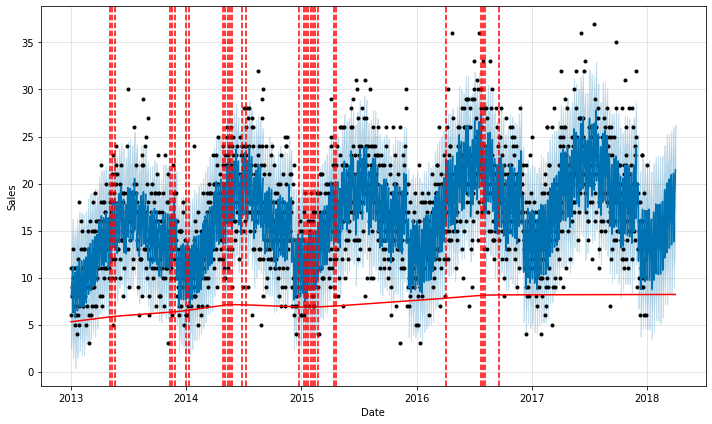

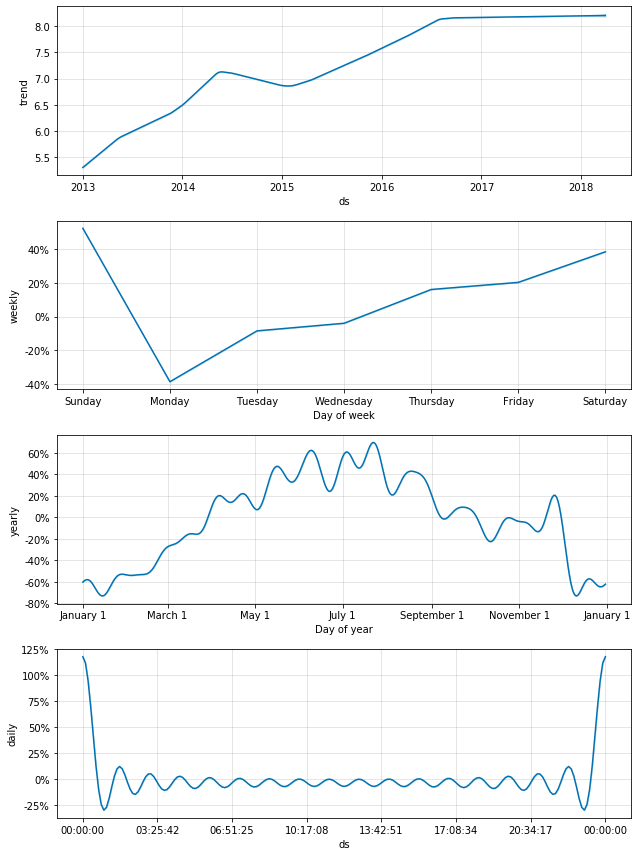

In [442]:
#Run Prophet for single item/store combinations and plot forecast
(ProphetModel(list_train_df_split)
     .predict_single(store_id=1, item_id=5)
)

In [443]:
#Predict in rounds for full dataset
df_predictions_prophet = (ProphetModel(list_train_df_split)
                              .predict_all()
                         )

In [444]:
df_predictions_prophet.head()

,date,store,item,actual_sales,predicted_sales
0,2013-01-01,1,1,13,9
1,2013-01-02,1,1,11,10
2,2013-01-03,1,1,14,10
3,2013-01-04,1,1,13,11
4,2013-01-05,1,1,10,12


In [445]:
#Set actual and predicted sales to calculate SMAPE 
y_actual_prophet = df_predictions_prophet[df_predictions_prophet['date'] < '2018-01-01']['actual_sales']
y_pred_prophet = df_predictions_prophet[df_predictions_prophet['date'] < '2018-01-01']['predicted_sales']

In [446]:
#Calculate MAPE
mean_absolute_error(y_actual_prophet, y_pred_prophet)

5.627278203723987

In [447]:
#Output predictions for first three months of 2018
predictions_prophet = (df_predictions_prophet[df_predictions_prophet['date'] >= '2018-01-01']
                           .reset_index()['predicted_sales']
                      )

In [448]:
len(predictions_prophet)

45000

In [451]:
predictions_prophet

0        12
1        15
2        16
3        17
4        18
         ..
44995    71
44996    73
44997    79
44998    85
44999    92
Name: predicted_sales, Length: 45000, dtype: int32

In [449]:
save_path = Path('../data/time_series_PROPHET_predictions.csv')

predictions_prophet.to_csv(save_path)